<p style="color:black;font-size:220%;text-align:center;"><strong>Построение рекомендательной системы в области закупок с учетом характеристик контракта

# Разделы: <a class="anchor" id="0"></a>

* [1. Введение](#1) 
* [2. Импорт библиотек](#2) 

* [3. Сбор датасета](#3)
    * [3.1. Сбор ИНН участников](#3.1)
    * [3.2. Функции для сбора остальной информации](#3.2)
    * [3.3. Сбор характеристики связей между контрагентами](#3.3)
    * [3.4. Сбор характеристики контрагентов](#3.4)
    * [3.5. Лемматизация](#3.5)
       
* [4. Анализ данных](#4)

* [5. Векторизация](#5)

* [6. Построение графа](#6)

* [7. Разделение на обучающую и тестовую выборки](#7)

* [8. Обучение](#8)
    * [8.1. GraphSAGE](#8.1)


<a id="1"></a>
# <b><span style='color:blue'>|</span> 1. Введение</b>
* [К оглавлению](#0)

    В современном мире рекомендательные системы используются в различных сферах, включая коммерцию, образование, медицину и государственное управление. В сфере закупок рекомендательные системы могут повысить эффективность выбора контрактных предложений, сократить временные затраты и снизить риски при заключении контрактов.

    Для построения рекомендательной системы важно учитывать конкретные характеристики контрактов, такие как объекты закупок, цены и сроки исполнения. Учитывание характеристик контракта приведут к верным рекомендациям, которые удовлетворяют потребности заказчика и соответствуют специфике отрасли.

    Цель данной курсовой работы заключается в разработке рекомендательной системы, которая учитывает характеристики контрактов и предоставляет заказчикам релевантные рекомендации. Для достижения этой цели будут использоваться методы машинного обучения и графовых баз данных, а также различные техники обработки данных и анализа текста.

    Задачи, которые будут решаться в рамках данной работы, включают в себя сбор и обработку данных о контрактах, построения графа знаний, разработку алгоритмов машинного обучения для построения рекомендаций, а также оценку качества разработанной системы с помощью метрик.

<a id="2"></a>
# <b><span style='color:blue'>|</span> 2. Импорт библиотек</b>
* [К оглавлению](#0)

In [691]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zipfile import ZipFile
import re
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlencode
import dask.bag as db
from dask.diagnostics import ProgressBar

import nltk
from nltk.corpus import stopwords
from collections import Counter
import pymorphy2

import torch
import torch.nn.functional as F
import dgl
import networkx as nx
import scipy.sparse as sp
import torch.nn as nn
import itertools
import dgl.function as fn
from dgl.nn import SAGEConv

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

<a id="3"></a>
# <b><span style='color:blue'>|</span> 3. Сбор датасета</b>
* [К оглавлению](#0)

<a id="3.1"></a>
### <b><span style='color:blue'>|</span> 3.1. Сбор ИНН участников</b>

Имеются архив ZIP и папка, имеющие протоколы разных форматов. Названия файлов содержат ИНН участников закупок (\[ИНН участника]_...), которые являются основой построения рекомендательной системы. Они отбираются с помощью функции TIN.

In [2]:
@np.vectorize
def TIN(filename: str) -> str:
    try: # в случае если попался не файл с закупкой
        new_file_name = re.match(r'[0-9]{9,}', filename).group(0)
        if len(new_file_name) == 9:
            return '0' + new_file_name
        else:
            return new_file_name
    except AttributeError:
        return np.nan

In [3]:
folder = "D:\УЧЕБА\курсовая работа\протоколы_ГосЗакупки_2"
file_names2 = np.array(os.listdir(folder))
with ZipFile(r"D:\УЧЕБА\курсовая работа\протоколы_ГосЗакупки.zip", 'r') as zip:
    file_names1 = np.array(zip.namelist())
file_names = np.concatenate((file_names1, file_names2))

In [4]:
%%time
tins = np.unique(TIN(file_names)).tolist()
tins[:5]

Wall time: 5.02 ms


['0256006322', '0268008010', '0268069694', '0270007455', '0274110679']

<a id="3.2"></a>
### <b><span style='color:blue'>|</span> 3.2. Функции для сбора остальной информации</b>

На сайте zakupki.gov.ru, содержащий историю закупок контрагентов, рассматриваются до 50 (включительно) закупок каждого участника, в каждой из которых отбираются начальная цена закупки, объект закупки и ИНН заказчика.

In [23]:
def find_characteristics(tin):
    list_characts = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    params = {
        'pageNumber': 1,
        'search-filter': 'Дата размещения',
        'fz44': 'on',
        'fz223': 'on',
        'participantName': tin,
        'sortBy': 'UPDATE_DATE',
        'recordsPerPage': '_50',
    }
    base_url = 'https://zakupki.gov.ru/epz/order/extendedsearch/results.html?'
    url = base_url + urlencode(params)
    with requests.get(url, headers=headers) as response:
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'lxml')
        s_pr = soup.find_all('div', class_='price-block__value')
        s_numb = soup.find_all('div', class_='registry-entry__header-mid__number')
        s_links = soup.find_all('div', class_='registry-entry__body-href')
        for card in range(min(len(s_pr), len(s_numb))):
            if s_pr[card] != [] and s_numb[card] != [] and s_links[card] != []:
                cost = str(''.join(re.findall(r'\d|,', str(s_pr[card].contents[0]))).replace(',', '.'))
                number = str(re.search(r'\d+', s_numb[card].a.contents[0]).group(0))
                link = 'https://zakupki.gov.ru/' + s_links[card].a['href']
                list_characts.append([number, tin, cost, link])
            else:
                list_characts.append([np.nan, np.nan, np.nan, np.nan])
    return list_characts

In [24]:
def find_tin_cust(row):
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
        with requests.get(row[2], headers=headers) as response:
            response.raise_for_status()
            soup1 = BeautifulSoup(response.text, "lxml")
            s1 = soup1.find_all('div', class_ ='registry-entry__body-value')
            row_tin_cust = [row[0], row[1], str(s1[2].contents[0])]
    except:
        row_tin_cust = [np.nan, np.nan, np.nan]
    return row_tin_cust

In [25]:
def find_objects(tin):
    list_objs = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    params = {
        'pageNumber': 1,
        'search-filter': 'Дата размещения',
        'fz44': 'on',
        'fz223': 'on',
        'participantName': tin,
        'sortBy': 'UPDATE_DATE',
        'recordsPerPage': '_20',
    }
    base_url = 'https://zakupki.gov.ru/epz/order/extendedsearch/results.html?'
    url = base_url + urlencode(params)
    with requests.get(url, headers=headers) as response:
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'lxml')
        s_obj = soup.find_all('div', class_='registry-entry__body-value')
        for card in range(len(s_obj)):
            if s_obj[card] != []:
                object_ = str(s_obj[card].contents[0])
                list_objs.append(object_)
            else:
                list_objs.append(np.nan)
    return [tin, list_objs]

<a id="3.3"></a>
### <b><span style='color:blue'>|</span> 3.3. Сбор характеристики связей между контрагентами</b>

Для ускорения процесса сбора датасета используется dask.bag, который в свою очередь использует мультипроцессинг. Данные конвертируется в датафрейм, содержащий ссылку на ИНН заказчиков. Так как bag **неупорядоченная коллекция**, для получения ИНН заказчика также используются ID и ИНН участника, потому что вместе они уникальны в таблице. Затем данные конкатенируются, исключаются строки, содержащие пустоты. Таблица используется для задания свойств рёбер.
Сбор данных был разделён на две функции в целях ускорения и оптимизации.

In [12]:
with ProgressBar():
    list_characts = db.from_sequence(tins).map(find_characteristics).compute()

[########################################] | 100% Completed | 56.41 s


In [13]:
data_links = pd.DataFrame({'Characteristics': list_characts}).explode('Characteristics').reset_index(drop=True)
new_cols = data_links['Characteristics'].apply(pd.Series)
new_cols.columns = ['ID', 'TIN of Participant', 'Initial Price', 'Link to Customers TIN']
data_links = pd.concat([data_links.drop('Characteristics', axis=1), new_cols], axis=1)
data_links.head()

,ID,TIN of Participant,Initial Price,Link to Customers TIN
0,32211557847,0256006322,9483808.33,https://zakupki.gov.ru//epz/organization/view2...
1,32110296447,0256006322,3240000.00,https://zakupki.gov.ru//epz/organization/view2...
2,32110068299,0256006322,8785370.84,https://zakupki.gov.ru//epz/organization/view2...
3,32009647275,0256006322,137760.00,https://zakupki.gov.ru//epz/organization/view2...
4,32009347076,0256006322,4431008.33,https://zakupki.gov.ru//epz/organization/view2...


In [14]:
data_links.shape

(13566, 4)

In [15]:
data_links.drop_duplicates(subset=['ID', 'TIN of Participant']).shape

(13566, 4)

In [16]:
data_for_cust_tins = data_links[['ID', 'TIN of Participant', 'Link to Customers TIN']]

In [17]:
with ProgressBar():
    cust_tins = db.from_sequence(data_for_cust_tins.values.tolist()).map(find_tin_cust).compute()

[########################################] | 100% Completed | 15m 14s


In [18]:
data_tins = pd.DataFrame({'Info': cust_tins})
new_cols = data_tins['Info'].apply(pd.Series)
new_cols.columns = ['ID', 'TIN of Participant', 'TIN of Customer']
data_tins = pd.concat([data_tins.drop('Info', axis=1), new_cols], axis=1)
data_tins

,ID,TIN of Participant,TIN of Customer
0,32211557847,0256006322,2709001590
1,32110296447,0256006322,2709001590
2,32110068299,0256006322,2709001590
3,32009647275,0256006322,2531002070
4,32009347076,0256006322,2709001590
...,...,...,...
13561,0864500000223000849,nan,6829128395
13562,0864500000223000860,nan,6829128395
13563,0864500000223000859,nan,6829128395
13564,0864500000223000854,nan,6829128395


In [30]:
finish_data = pd.merge(data_links, data_tins, on=['ID', 'TIN of Participant'])
finish_data = finish_data.drop('Link to Customers TIN', axis=1)
finish_data.dropna(inplace=True)
finish_data.head()

,ID,TIN of Participant,Initial Price,TIN of Customer
0,32211557847,0256006322,9483808.33,2709001590
1,32110296447,0256006322,3240000.00,2709001590
2,32110068299,0256006322,8785370.84,2709001590
3,32009647275,0256006322,137760.00,2531002070
4,32009347076,0256006322,4431008.33,2709001590


In [31]:
finish_data.to_csv('data_for_edges.csv', index=False)

<a id="3.4"></a>
### <b><span style='color:blue'>|</span> 3.4. Сбор характеристики контрагентов</b>

На основе полученной таблицы data_for_edges собираются и сортируются все ИНН контрагентов. У каждого рассматриваются до 20 (включительно) объектов в совершенных закупок.

In [36]:
data = pd.read_csv('data_for_edges.csv')
all_tins = pd.concat([data['TIN of Participant'], data['TIN of Customer']]).unique()
all_tins.sort()
all_tins[:5]

array([105018196, 105020004, 202008210, 207006200, 207007690], dtype=int64)

In [63]:
with ProgressBar():
    list_objects = db.from_sequence(all_tins).map(find_objects).compute()

[########################################] | 100% Completed | 571.48 s


In [120]:
data_objs = pd.DataFrame(list_objects, columns=['TIN', 'Purchase Object'])
data_objs

,TIN,Purchase Object
0,105018196,[Услуги по техническому обслуживанию газового ...
1,105020004,[Оказание услуг по повышению квалификации: цик...
2,202008210,[]
3,207006200,[]
4,207007690,[]
...,...,...
3901,9710042298,[Разработка проектов границ территорий и проек...
3902,9715226210,[]
3903,9729030514,[запрос предложений в электронной форме по отб...
3904,9901000235,[Предоставление Ресурсоснабжающей организацией...


<a id="3.5"></a>
### <b><span style='color:blue'>|</span> 3.5. Лемматизация</b>

Объекты каждого контрагента лемматизируются и соединяются в одну строку. Далее отбираются 8 слов в строке, которые встречаются чаще всего. Получаем таблицу, состоящую из ИНН контрагента и ограниченного списка слов из лемматизированных объектов. Таблица используется в качестве задания свтойств вершин будущего графа.

In [79]:
stop_words = set(stopwords.words('russian'))

In [112]:
def lemmatize_text(lst):
    new_lst = []
    for text in lst:
        text = re.sub(r'[^\w\s]', '', text)
        lemmas = []
        for word in text.split():
            if word not in stop_words:
                parsed_word = morph.parse(word)[0]
                lemma = parsed_word.normal_form
                lemmas.append(lemma)
        new_lst.append(' '.join(lemmas))
    return ' '.join(new_lst).split()
morph = pymorphy2.MorphAnalyzer()

In [121]:
%%time
data_objs['Purchase Object'] = data_objs['Purchase Object'].apply(lemmatize_text)

Wall time: 1min 23s


In [123]:
data_objs['Purchase Object'] = data_objs['Purchase Object'].apply(lambda x: ' '.join([word for word, freq in Counter(x).most_common(8)]))
data_objs.head(8)

,TIN,Purchase Object
0,105018196,газовый услуга оборудование технический обслуж...
1,105020004,оказание услуга повышение квалификация среднее...
2,202008210,
3,207006200,
4,207007690,
5,210003329,
6,210003368,
7,210003590,обучение район возраст гражданин дисциплина ос...


In [124]:
data_objs.to_csv('data_for_nodes.csv', index=False)

<a id="4"></a>
# <b><span style='color:blue'>|</span> 4. Анализ данных</b>
* [К оглавлению](#0)

Таблица data_nodes имеет пропуски, которые заполняются пустой строкой.

In [2]:
data_edges = pd.read_csv('data_for_edges.csv')
data_edges.head()

,ID,TIN of Participant,Initial Price,TIN of Customer
0,32211557847,256006322,9483808.33,2709001590
1,32110296447,256006322,3240000.00,2709001590
2,32110068299,256006322,8785370.84,2709001590
3,32009647275,256006322,137760.00,2531002070
4,32009347076,256006322,4431008.33,2709001590


In [3]:
data_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13282 entries, 0 to 13281
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  13282 non-null  int64  
 1   TIN of Participant  13282 non-null  int64  
 2   Initial Price       13282 non-null  float64
 3   TIN of Customer     13282 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 415.2 KB


In [4]:
data_edges.shape

(13282, 4)

In [5]:
data_nodes = pd.read_csv('data_for_nodes.csv')
data_nodes.head(8)

,TIN,Purchase Object
0,105018196,газовый услуга оборудование технический обслуж...
1,105020004,оказание услуга повышение квалификация среднее...
2,202008210,NaN
3,207006200,NaN
4,207007690,NaN
5,210003329,NaN
6,210003368,NaN
7,210003590,обучение район возраст гражданин дисциплина ос...


In [6]:
data_nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TIN              3906 non-null   int64 
 1   Purchase Object  2718 non-null   object
dtypes: int64(1), object(1)
memory usage: 61.2+ KB


In [7]:
data_nodes.shape

(3906, 2)

In [8]:
data_nodes = data_nodes.fillna('')

<a id="5"></a>
# <b><span style='color:blue'>|</span> 5. Векторизация</b>
* [К оглавлению](#0)

Полученные "объекты" векторизируются, так как в качестве свойств графа нельзя использовать данные формата str.

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_nodes['Purchase Object'].tolist())
nodes_features = torch.tensor(X.toarray())
nodes_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

<a id="6"></a>
# <b><span style='color:blue'>|</span> 6. Построение графа</b>
* [К оглавлению](#0)

ИНН контрагентов сортируются и нумеруются от 0 до 3906, чтобы построить граф. Задаются свойства вершин - объекты закупки, свойства рёбер - начальная цена.

In [130]:
def encode_columns(col1, col2):
    sorted_values = sorted(np.unique(data_edges[['TIN of Participant', 'TIN of Customer']].to_numpy()).tolist())
    mapping = {val: i for i, val in enumerate(sorted_values)}
    return pd.DataFrame({'TIN of Participant encoded': [mapping[val] for val in col1],
                         'TIN of Customer encoded': [mapping[val] for val in col2]})

In [131]:
nodes = encode_columns(data_edges['TIN of Participant'], data_edges['TIN of Customer'])
nodes.head()

,TIN of Participant encoded,TIN of Customer encoded
0,39,878
1,39,878
2,39,878
3,39,762
4,39,878


In [136]:
g = dgl.graph((nodes['TIN of Participant encoded'], nodes['TIN of Customer encoded']))

In [137]:
g.edges()[0].shape

torch.Size([13282])

In [138]:
g.ndata['objects'] = nodes_features

In [139]:
g.edata['price'] = torch.tensor(data_edges['Initial Price'])

In [140]:
g

Graph(num_nodes=3906, num_edges=13282,
      ndata_schemes={'objects': Scheme(shape=(3390,), dtype=torch.float64)}
      edata_schemes={'price': Scheme(shape=(), dtype=torch.float64)})

<a id="7"></a>
# <b><span style='color:blue'>|</span> 7. Разделение на обучающую и тестовую выборки</b>
* [К оглавлению](#0)

Граф g раздеялется на тренировочный и тестовый наборы граней.
Сначала определяются все ребра графа g путем получения их исходных и конечных узлов u и v, а затем происходит перетасовка случайного порядка всех ребер. Далее вычисляется количество граней, которые будут использоваться в качестве тестового набора, которое равно 10% от общего количества ребер. Затем создаются тестовый и обучающий наборы граней.
В итоге, тренировочный граф, и соответствующие ему положительные графы готовы для обучения модели, а тестовые графы для оценки качества работы модели.

In [692]:
u, v = g.edges()

eids = np.arange(g.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(3906, 3906))
adj_neg = 1 - adj.todense() - np.eye(g.num_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.num_edges())
test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)

In [693]:
neg_u

array([   0,    0,    0, ..., 3905, 3905, 3905], dtype=int64)

In [694]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [695]:
train_g

Graph(num_nodes=3906, num_edges=11954,
      ndata_schemes={'objects': Scheme(shape=(3390,), dtype=torch.float64)}
      edata_schemes={'price': Scheme(shape=(), dtype=torch.float64)})

In [696]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.num_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.num_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.num_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.num_nodes())

In [697]:
train_pos_g

Graph(num_nodes=3906, num_edges=11954,
      ndata_schemes={}
      edata_schemes={})

In [698]:
train_neg_g

Graph(num_nodes=3906, num_edges=11954,
      ndata_schemes={}
      edata_schemes={})

<a id="8"></a>
# <b><span style='color:blue'>|</span> 8. Обучение</b>
* [К оглавлению](#0)

<a id="8.1"></a>
### <b><span style='color:blue'>|</span> 8.1. GraphSAGE</b>

Создается и обучается двухслойная модель `GraphSAGE`, которая используется для предсказания связей между вершинами. Класс `DotPredictor` определяет предиктор, который вычисляет новый атрибут для каждого ребра, вычисляя произведение скалярного произведения между векторами свойств узлов на каждом конце ребра. Затем определены функции для вычисления потерь, показателей точности. Функция потерь вычисляет бинарную перекрестную энтропию между прогнозируемыми оценками и истинными метками. В цикле обучения для каждой эпохи производится прямой проход через модель, вычисляются потери и производится обратное распространение ошибки, после чего обновляются веса модели. Для оценки качества работы модели используются разные метрики (`F1 score, Accuracy, ROC-AUC score, Confusion matrix`).


In [699]:
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [700]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

In [701]:
model = GraphSAGE(train_g.ndata["objects"].shape[1], 16)
model = model.double()
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)
def compute_f1(pos_prob, neg_prob):
    scores = torch.cat([pos_score, neg_score]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return f1_score(labels, pred_labels)
def compute_accuracy(pos_prob, neg_prob):
    scores = torch.cat([pos_score, neg_score]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return accuracy_score(labels, pred_labels)
def compute_conf_matrix(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return confusion_matrix(labels, pred_labels)

In [702]:
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred.parameters()), lr=0.01
)

In [703]:
%%time
loss_values = []
f1_values = []
for e in range(110):
    # forward
    h = model(train_g, train_g.ndata["objects"])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    f1_sc = compute_f1(torch.sigmoid(pos_score), torch.sigmoid(neg_score))
    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, round(loss.item(), 5)))
    loss_values.append(loss.item())
    f1_values.append(f1_sc)

In epoch 0, loss: 0.71479
In epoch 5, loss: 0.66261
In epoch 10, loss: 0.59134
In epoch 15, loss: 0.51976
In epoch 20, loss: 0.46803
In epoch 25, loss: 0.42045
In epoch 30, loss: 0.37221
In epoch 35, loss: 0.32711
In epoch 40, loss: 0.28568
In epoch 45, loss: 0.24832
In epoch 50, loss: 0.21446
In epoch 55, loss: 0.1841
In epoch 60, loss: 0.15712
In epoch 65, loss: 0.1333
In epoch 70, loss: 0.11302
In epoch 75, loss: 0.09561
In epoch 80, loss: 0.08094
In epoch 85, loss: 0.06875
In epoch 90, loss: 0.05873
In epoch 95, loss: 0.05046
In epoch 100, loss: 0.04366
In epoch 105, loss: 0.03804
Wall time: 6.58 s


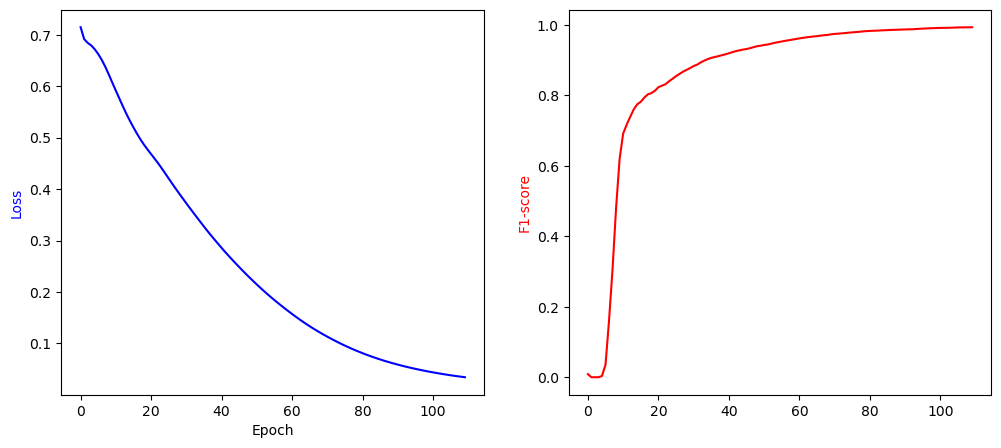

In [704]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# первый график
axs[0].plot(loss_values, 'blue')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss', color='blue')

axs[1].plot(f1_values, 'red')
axs[1].set_ylabel('F1-score', color='red')

# отображаем графики
plt.show()

In [705]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    pos_prob = torch.sigmoid(pos_score)
    neg_prob = torch.sigmoid(neg_score)
    print (f"Accuracy: {round(compute_accuracy(pos_score, neg_score), 5)}")
    print (f"AUC: {round(compute_auc(pos_score, neg_score), 5)}")
    print (f"F1-score: {round(compute_f1(pos_prob, neg_prob), 5)}")

Accuracy: 0.69955
AUC: 0.79202
F1-score: 0.74763


In [706]:
print (f"Confusion matrix: \n{compute_conf_matrix(pos_prob, neg_prob)}")

Confusion matrix: 
[[ 645  683]
 [ 126 1202]]


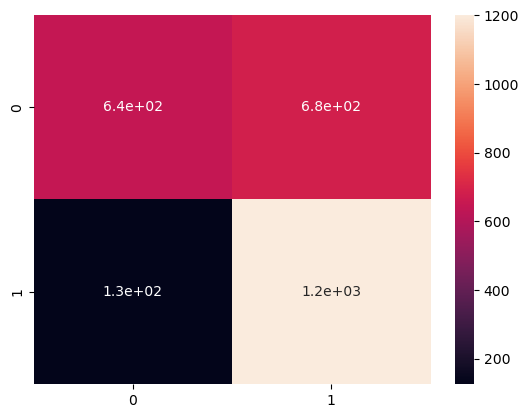

In [707]:
sns.heatmap(compute_conf_matrix(pos_prob, neg_prob), annot=True)
plt.show()